# ML: pipeline (Домашнее задание)

Продолжаем работать с датасетом про морских ракушек (ABALONE) - в нем содержатся их различные характеристики- пол, размеры, вес и возраст.

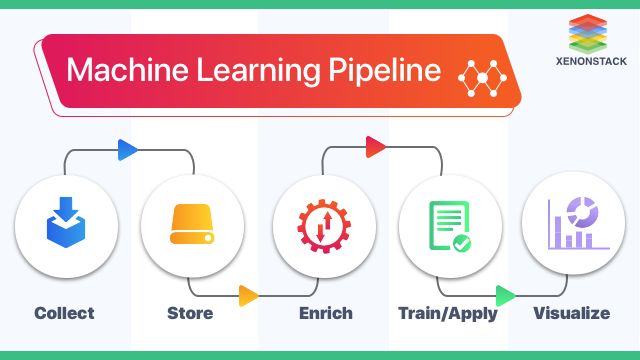

**План на работу:**

* Построение моделей на числовых признаках 'Байесовского хребта'  и kNN с параметрами по умолчанию, вычисление метрик

* Подбор гиперпараметров  (только на числовых признаках) при помощи GridSearchCV + вычисление метрик

* Добавление категориальных признаков в лучшую модель, обучение модели и заново подбор ее гиперпараметров + вычисление метрик

* Построение Explainer Dashboard

* Анализ модели в Explainer Dashboard

## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ABALONE_DATASET = "datasets/abalone_clear.csv"

In [ ]:
df = pd.read_csv(ABALONE_DATASET)

## Описание данных

- <b>Sex</b> - nominal - M, F, and I (недоросль)

- <b>Length</b> - Длина ракушки, мм

- <b>Diameter</b> - диаметр ракушки, мм

- <b>Height</b> - высота ракушки, мм

- <b>Whole weight</b> - вес ракушки, гр

- <b>Shucked weight</b> - вес мяса ракушки, гр

- <b>Viscera weight</b> - вес внутреностей ракушки, гр

- <b>Shell weight</b> - вес раковины после усушки, гр

- <b>Rings</b> - Возраст(кольца) -целевой параметр, Int

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## Построение моделей на числовых признаках :
### Наивный байесовский классификатор

Байесовская регрессия позволяет естественному механизму выжить при недостаточном количестве данных или плохо распределенных данных путем формулирования линейной регрессии с использованием распределителей вероятностей, а не точечных оценок. Предполагается, что выходной сигнал или ответ «y» взят из распределения вероятностей, а не оценивается как единое значение.

Математически, чтобы получить полностью вероятностную модель, предполагается, что отклик y распределен по Гауссу вокруг следующим образом

$$p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha^{-1})$$

Одним из наиболее полезных типов байесовской регрессии является регрессия Байесовского хребта, которая оценивает вероятностную модель проблемы регрессии. Здесь априор для коэффициента w задается сферическим гауссианом следующим образом:

$$p(w|\lambda) =\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})$$


Параметры $$\alpha,   \lambda   ,    w $$
  
оцениваются совместно во время апроксимации модели путем максимизации логарифмического предельного правдоподобия.
Эта полученная модель называется регрессией байесовского хребта и в scikit-learn модуль
sklearn.linear_model.BeyesianRidge  используется для регрессии Байесовского хребта.


In [ ]:
# Импорт библиотек
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error

In [ ]:
# Убираем целевую колонку с возрастом и категориальную с полом
X = df.drop(['Rings', 'Sex'], axis=1)
y = df['Rings']

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Инициализация модели регрессии наивного Байесовского хребта
nb_model = BayesianRidge()

In [ ]:
# Обучение модели
nb_model.fit(X_train, y_train)

BayesianRidge()

In [ ]:
# Предсказание на тестовых данных
y_pred = nb_model.predict(X_test)

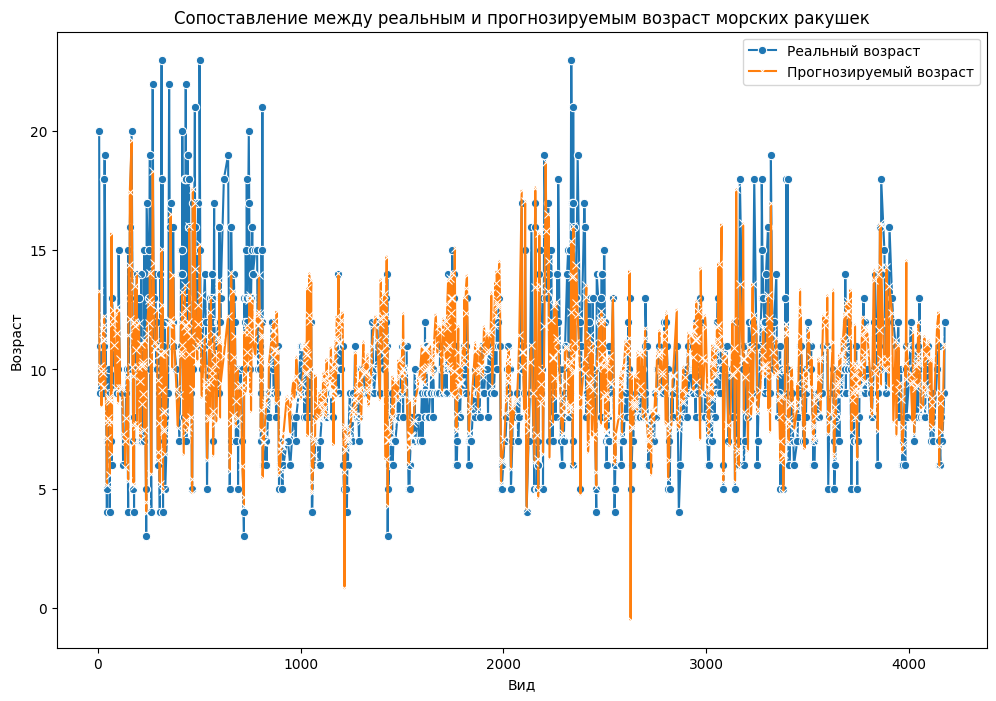

In [ ]:
# График между предсказанными данными с фактическим

df_compare = pd.DataFrame({'Реальный возраст': y_test, 'Прогнозируемый возраст': y_pred})
plt.figure(figsize=(12, 8))
sns.lineplot(x=df_compare.index, y='Реальный возраст', data=df_compare, label='Реальный возраст', marker='o')
sns.lineplot(x=df_compare.index, y='Прогнозируемый возраст', data=df_compare, label='Прогнозируемый возраст', marker='x')
plt.title('Сопоставление между реальным и прогнозируемым возраст морских ракушек.(Байесовского хребет)')
plt.xlabel('Вид')
plt.ylabel('Возраст')
plt.legend()
plt.show()

In [ ]:
#красиво но количествено не информативно
# Посмотрим на разницу между прогнозом и фактическим возрастом в процентах %
mpe_nb_model = (mean_absolute_error(y_test, y_pred) / np.mean(y_test)) * 100

print(f'{round(mpe_nb_model,2)} %')

16.92  %


## kNN
Алгоритм k ближайших соседей (kNN) - это простой, но мощный метод машинного обучения, используемый для задач классификации и регрессии.
Одним из важнейших аспектов эффективного применения алгоритма kNN является выбор соответствующих гиперпараметров, которые определяют,
как будет структурирована модель во время обучения. Выбор подходящих гиперпараметров может существенно повлиять на производительность модели,
повышая ее точность и способность обобщать невидимые данные.

## kNN + GridSearch
это метод , который позволяет оптимизировать гиперпараметры модели kNN.

Процесс GridSearch включает в себя:

1. Выбор диапазона возможных значений для каждого гиперпараметра.
2. Тренировку модели KNN на обучающей выборке и оценку её производительности на выборке для проверки. Для измерения производительности можно использовать такие метрики, как точность, F1-оценка, точность и отзыв.
3. Выбор лучших гиперпараметров — идентификация комбинации, которая показала лучшую производительность на выборке для проверки.

Использование GridSearch упрощает процесс построения модели, поскольку позволяет оценить каждый параметр модели без необходимости ручной проверки каждого отдельного параметра.
Однако процесс настройки гиперпараметров может потребовать времени, так как число возможных комбинаций параметров быстро увеличивается.

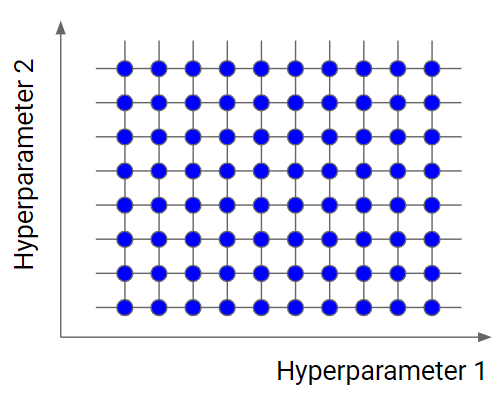

In [ ]:
# импорт библиотек
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:

df = pd.read_csv('datasets/abalone_clear.csv')

# Убираем целевую колонку с возрастом и категориальную с полом
X = df.drop(['Rings', 'Sex'], axis=1)
y = df['Rings']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Нормализуем признаки (рекомендуется для KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Создаем и обучаем модель KNN регрессии
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train_scaled, y_train)

# Прогноз
y_pred = knn_regressor.predict(X_test_scaled)


In [ ]:
mpe_knn_model = (mean_absolute_error(y_test, y_pred)/ np.mean(y_test)) * 100
print(f'{round(mpe_knn_model,2)} %')

17.55 %


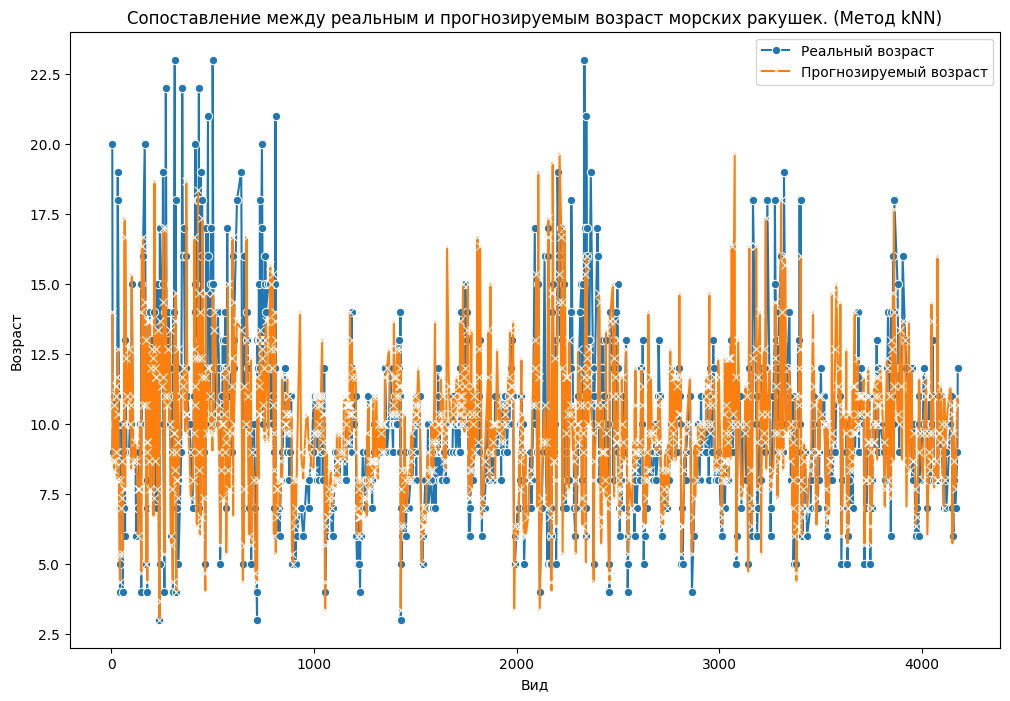

In [ ]:
# тоже результат
# построим графики.Графики лучше чем 17,5 процентов.

df_compare = pd.DataFrame({'Реальный возраст': y_test, 'Прогнозируемый возраст': y_pred})
plt.figure(figsize=(12, 8))
sns.lineplot(x=df_compare.index, y='Реальный возраст', data=df_compare, label='Реальный возраст', marker='o')
sns.lineplot(x=df_compare.index, y='Прогнозируемый возраст', data=df_compare, label='Прогнозируемый возраст', marker='x')
plt.title('Сопоставление между реальным и прогнозируемым возраст морских ракушек. (Метод kNN)')
plt.xlabel('Вид')
plt.ylabel('Возраст')
plt.legend()
plt.show()

In [ ]:
param_grid = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],  # 'uniform' - все соседи равнозначны, 'distance' - веса обратно пропорциональны расстоянию
    'metric': ['euclidean', 'manhattan']  # Различные метрики расстояния
}


In [ ]:
# Создаем объект GridSearchCV
grid_search = GridSearchCV(knn_regressor, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)

# Проводим поиск по сетке с кросс-валидацией
grid_search.fit(X_train_scaled, y_train)

# Выводим лучшие параметры и результаты
print("Best params:", grid_search.best_params_)
print("Best MAE on train data:", -grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, wei

In [ ]:
# Делаем предсказания на тестовых данных с лучшей моделью
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test_scaled)

In [ ]:
# Оцениваем модель на тестовых данных
mpe_knnGS_model = (mean_absolute_error(y_test, y_pred)/ np.mean(y_test)) * 100
print(f'{round(mpe_knnGS_model,2)} %')

15.97 %


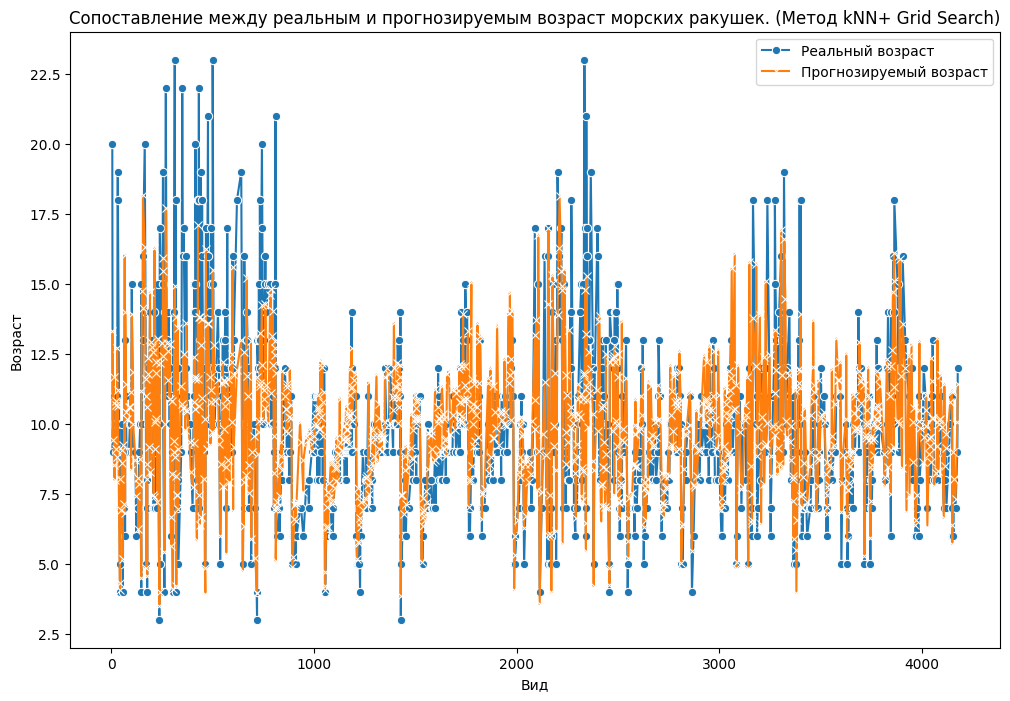

In [ ]:
# построим графики.Графики лучше даже чем 15,9 процентов.

df_compare = pd.DataFrame({'Реальный возраст': y_test, 'Прогнозируемый возраст': y_pred})
plt.figure(figsize=(12, 8))
sns.lineplot(x=df_compare.index, y='Реальный возраст', data=df_compare, label='Реальный возраст', marker='o')
sns.lineplot(x=df_compare.index, y='Прогнозируемый возраст', data=df_compare, label='Прогнозируемый возраст', marker='x')
plt.title('Сопоставление между реальным и прогнозируемым возраст морских ракушек. (Метод kNN+ Grid Search)')
plt.xlabel('Вид')
plt.ylabel('Возраст')
plt.legend()
plt.show()

In [3]:
# поскольку терять уже нечего идем в первый попавшийся случайный лес.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [5]:


df = pd.read_csv('datasets/abalone_clear.csv')

# Убираем целевую колонку с возрастом и категориальную с полом
X = df.drop(['Rings', 'Sex'], axis=1)
y = df['Rings']


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаем и обучаем модель Random Forest с параметрами по умолчанию
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
y_pred_random_forest = random_forest_model.predict(X_test)

# Оцениваем производительность модели
mae_random_forest = mean_absolute_error(y_test, y_pred_random_forest)

mpe_random_forest = (mae_random_forest / np.mean(y_test)) * 100
print(f'{round(mpe_random_forest,2)} %')

16.2 %


In [6]:
# пробуем гиперпараметры
from sklearn.model_selection import GridSearchCV

In [7]:
# Создаем и обучаем модель Random Forest
random_forest_model = RandomForestRegressor(random_state=42)

# Определение параметров для Grid Search
param_grid = {
    'max_depth': [4, 7, 10], 'max_features': [0.7, 0.8, 0.9], 'n_estimators': [150, 200, 250]
}

grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)

grid_search.fit(X_train, y_train)


# Вывод лучших параметров и результатов
print("Best params:", grid_search.best_params_)

# Делаем предсказания на тестовых данных с лучшей моделью
best_model_random_forest = grid_search.best_estimator_
y_pred_random_forest = best_model_random_forest.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....max_depth=4, max_features=0.7, n_estimators=150; total time=   0.8s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=150; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=150; total time=   0.5s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=150; total time=   0.5s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=150; total time=   0.5s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=250; total time=   0.8s
[CV] END ....max_depth=4, max_features=0.7, n_e

In [ ]:
# Оцениваем производительность модели
mae_random_forest_best = mean_absolute_error(y_test, y_pred_random_forest)
mpe_random_forest_best = (mae_random_forest_best / np.mean(y_test)) * 100

print(f'{round(mpe_random_forest_best,2)} %')

15.7 %


In [8]:
# в лес -> так в лес

## Учет категориальных признаков

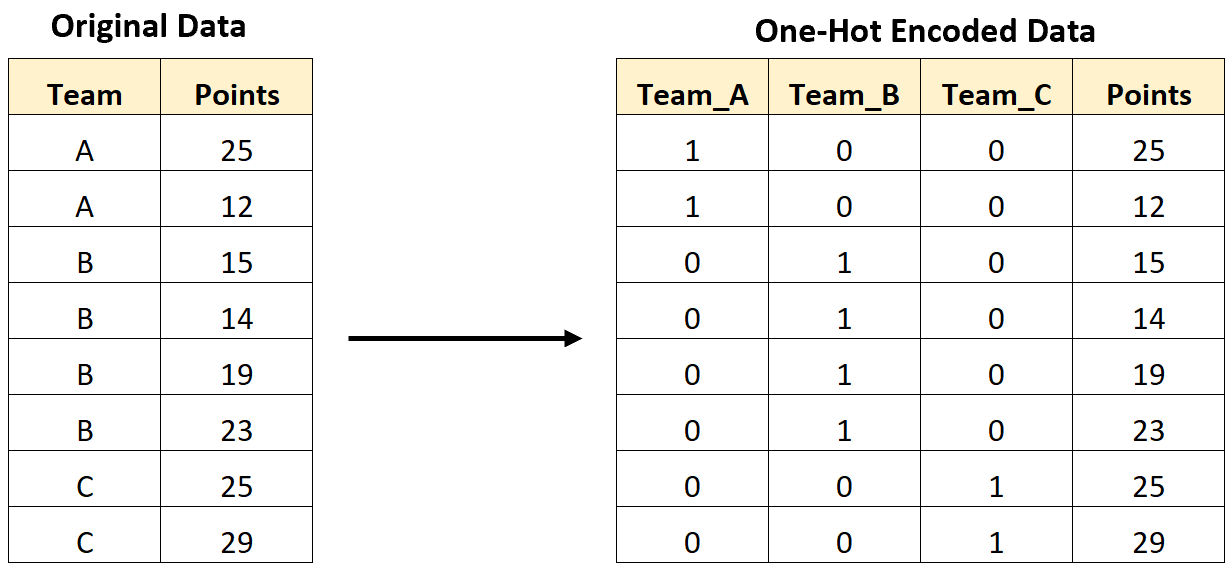

In [9]:
# у нас по плану: Добавление категориальных признаков в лучшую модель, обучение модели и заново подбор ее гиперпараметров + вычисление метрик

In [10]:
df = pd.read_csv('datasets/abalone_clear.csv')

# Преобразование категориального признака "Sex" с использованием One-Hot Encoding
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex', drop_first=True)

# Убираем целевую колонку с возрастом
X = df.drop(['Rings'], axis=1)
y = df['Rings']

# Создаем и обучаем модель Random Forest
random_forest_model = RandomForestRegressor(random_state=42)

# Определение параметров для Grid Search
param_grid = {
    'max_depth': [4, 7, 10], 'max_features': [0.7, 0.8, 0.9], 'n_estimators': [170, 200, 230]
}

grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)

grid_search.fit(X_train, y_train)

# Вывод лучших параметров и результатов
print("Best params:", grid_search.best_params_)

# Делаем предсказания на тестовых данных с лучшей моделью
best_model_random_forest = grid_search.best_estimator_
y_pred = best_model_random_forest.predict(X_test)

# Оцениваем производительность модели
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE Random Forest Best: {mae:.2f}')
mpe = (mae / np.mean(y_test)) * 100
print(f'MAE Random Forest Best: {mae:.2f}', f'Mean Percentage Error: {mpe:.2f}%')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....max_depth=4, max_features=0.7, n_estimators=170; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=170; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=170; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=170; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=170; total time=   0.6s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=200; total time=   0.9s
[CV] END ....max_depth=4, max_features=0.7, n_estimators=230; total time=   1.1s
[CV] END ....max_depth=4, max_features=0.7, n_e

In [ ]:
# добавим немного метрики


In [11]:
import sklearn.metrics

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<b>Mean Absolute Error (MAE)</b>
* Оценка: MAE измеряет среднюю абсолютную ошибку между фактическими и предсказанными значениями. Чем ближе MAE к нулю, тем лучше. Высокие значения MAE могут указывать на значительные ошибки модели.
* Переобучение: Если MAE на тренировочных данных существенно меньше, чем на тестовых, это может свидетельствовать о переобучении.

<b>Mean Squared Error (MSE)</b>
* Оценка: MSE измеряет среднюю квадратичную ошибку. Он штрафует большие ошибки сильнее, чем MAE. Значения MSE близкие к нулю указывают на хорошую модель.
* Переобучение: Если MSE на тренировочных данных существенно меньше, чем на тестовых, это также может свидетельствовать о переобучении.

<b>R-squared (R2)</b>
* Оценка: R2 измеряет долю дисперсии целевой переменной, объясненной моделью. Значения близкие к 1 указывают на хорошую соответствие модели данным.
* Переобучение: Если R2 на тренировочных данных гораздо выше, чем на тестовых, это может быть признаком переобучения.

In [13]:
# Делаем предсказания на тренировочных данных с лучшей моделью
y_train_pred = best_model_random_forest.predict(X_train)

# Вычисляем метрики для тренировочных данных
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Вывод результатов для тренировочных данных
print('Tренировочные данные:')
print(f'MAE: {mae_train:.2f}')
print(f'MSE: {mse_train:.2f}')
print(f'R2: {r2_train:.2f}')

print()

# Вывод результатов для тестовых данных
print('Тестовые данные:')
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2:.2f}')

Tренировочные данные:
MAE: 1.03
MSE: 1.90
R2: 0.82

Тестовые данные:
MAE: 1.55
MSE: 4.70
R2: 0.54


 Вывод: Согласно метрике R2 имеет место некоторое переобучение модели

In [14]:
# ну и в конце (согласно плану) о красоте:

###  Построение  и анализ в Explainer Dashboard



### Permutation Importance

Перестановочная важность - это метод, который оценивает важность признаков путем перестановки значений каждого признака и измерения того, насколько это влияет на качество модели

Принцип работы: Для каждого признака модель обучается на данных с переставленными значениями этого признака, а затем оценивается изменение в метрике качества модели (например, точность, AUC и т. д.) после перестановки. Чем больше изменение метрики, тем более важен этот признак.

Преимущества: Прост в интерпретации и применении, не требует изменения модели.

Недостатки: Может быть вычислительно затратным для больших наборов данных и моделей.

### SHAP (SHapley Additive exPlanations):
Описание: SHAP - это метод, основанный на теории кооперативных игр (теории Шепли), который предоставляет объяснения для каждого предсказания модели, определяя вклад каждого признака в предсказание.

Принцип работы: SHAP оценивает вклад каждого признака в предсказание путем учитывания его вклада в каждую возможную комбинацию признаков. Это делается путем рассмотрения всех возможных подмножеств признаков и вычисления среднего вклада каждого признака в предсказание на основе всех возможных комбинаций.

Преимущества: Предоставляет интерпретируемые объяснения для отдельных предсказаний, учитывает взаимодействия между признаками.

Недостатки: Может быть вычислительно сложным, особенно для моделей с большим числом признаков и/или большими объемами данных.

### Shapley values

Процесс вычисления Shapley Values включает следующие шаги:

*  *Определение коалиции*: коалиция представляет собой подмножество признаков. Пустое подмножество (без признаков) и полное множество (со всеми признаками) также рассматриваются.

*  *Вычисление вклада*: для каждой коалиции вычисляется вклад каждого признака в предсказание модели. Это делается путем сравнения предсказания модели с добавленным признаком и без него.

*  *Суммирование вкладов*: все вклады суммируются по различным коалициям, учитывая их вероятность появления. Вероятность каждой коалиции вычисляется на основе количества перестановок признаков.

*   *Нормализация*: итоговые Shapley Values нормализуются для обеспечения свойства справедливости (additivity) и учета общей предсказательной способности модели.

#
Полезные ссылки:

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Census%20income%20classification%20with%20scikit-learn.html

#

[tutorial](https://github.com/oegedijk/explainerdashboard/blob/c7c515c05c5a161226193e40a8258c310fc7901d/notebooks/dashboard_examples.ipynb)

In [16]:
!pip install explainerdashboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.6 MB/s eta 0:00:00


In [17]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard, RegressionExplainer

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
# Создаем Explainer
explainer = RegressionExplainer(best_model_random_forest, X_test, y_test)


#explainer = ClassifierExplainer(gs.best_estimator_, X_test_transformed.iloc[:10], y_test_full.iloc[:10])

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [20]:
# Создаем ExplainerDashboard
db = ExplainerDashboard(explainer, title="Random Forest Explainer Dashboard",
                        whatif=False).run()

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#
Примеры дашбордов

https://titanicexplainer.herokuapp.com

Выводы из дашборда:

Значения метрик :

* mean square error - 4,667
* root mean squared error - 2,16
* mean absolute error - 1,532
* mean absolute percentage error - 0,153
* r-squared - 0,546

Исходя из этих метрик, можно сказать, что модель имеет некоторую степень точности в прогнозировании.Но всегда есть место для улучшений.

Также можно сказать, что наибольший вклад в результат по методикам Permutation importance и SHAP вносят Shell weight(вес ракушки) и Shucked weight(вес мяса) и height(размер).
Или другими словами чем толще и больше эти жители мирового океана, тем больше им годиков.

По индивидумам

* 1.объект с индексом 2622

Predictet 12.999

Observed  13.0

#
красавчик, тут комментировать только портить

* 2. объект с индексом 3027

Predicted 12.044

Observed 8.0

Согласно Contribution plot все негативное воздействие на прогноз оказал малый общий вес индивидума -0,29 при среднем общ.весе в 0,53. Кроме того согласно Partial Dependence Plot  в возрасте от 10 до 14 наблюдается резкий подъем в общем весе (может этап взросления особей).




In [ ]:
#